## LOCAL NOTEBOOK FOR UNSUPERVISED LEARNING AND NEWS ANALYSIS OF INDONESIAN-NEWS-DATASET FROM KAGGLE

In [1]:
%pip install pandas numpy seaborn matplotlib scikit-learn python-dotenv tensorflow llama-index

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import warnings
import re
from collections import Counter

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

from dotenv import load_dotenv

from llama_index.embeddings.openai import OpenAIEmbedding

from llama_index.core import (
    load_index_from_storage,
    StorageContext,
    Document,
    VectorStoreIndex,
    get_response_synthesizer
)

from llama_index.core.retrievers import VectorIndexRetriever
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.postprocessor import SimilarityPostprocessor

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

import sys
import tensorflow as tf
from tensorflow.keras import preprocessing
sys.modules['keras.src.preprocessing'] = preprocessing

In [2]:
warnings.filterwarnings('ignore')

# Loading Data
Nb: Used parquet instead of csv to preserve data type

In [3]:
df = pd.read_parquet('../data/data_tsne.parquet.gzip')

Nb: Pre-loaded tsne-2d and tsne-3d to not waste time processing.

In [4]:
df.head()

id source                                              title  \
0   0  tempo  Kapolri Instruksikan Proses Tegas Kasus Suap P...   
1   1  tempo  Terdampak Banjir, Mentan Siap Bantu Petani di ...   
2   2  tempo  Kementan Upayakan Perizinan Mudah, Cepat, dan ...   
3   3  tempo  Wapres Maruf Amin Dorong Pengusaha Sawit Perku...   
4   4  tempo  Menpan RB: Minat ASN Muda Pindah ke IKN Nusant...   

                                             content  \
0  TEMPO.CO, Yogyakarta- Kapolri Jenderal Listyo ...   
1  INFO NASIONAL - Menteri Pertanian Syahrul Yasi...   
2  INFO NASIONAL - Kementerian Pertanian memastik...   
3  INFO NASIONAL  Para pengusaha yang tergabung d...   
4  TEMPO.CO, Malang - Menteri Pendayagunaan Apara...   

                                           embedding  tsne-2d-1  tsne-2d-2  \
0  [0.006670293, -0.008296051, 0.018612592, -0.01...  29.873199   1.401189   
1  [-0.013915301, -0.018322684, 0.012273976, -0.0... -46.414150  -4.596785   
2  [0.015555209, -0.015595161, -0.001956054, -0.0... -50.386646  -3.093976   
3  [0.0035903626, -0.015759699, 0.008853396, -0.0... -50.196079  -0.174417   
4  [-0.00013789257, -0.03197872, 0.012931213, 0.0... -13.652273  16.243923   

   tsne-3d-1  tsne-3d-2  tsne-3d-3  
0  18.658846   6.101427   3.910203  
1 -20.185184  -2.371418  -8.996706  
2 -21.070637  -2.328195  -5.975774  
3 -23.908243   0.352373  -4.074963  
4  -3.523464   4.716335   0.848294

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32294 entries, 0 to 32293
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         32294 non-null  int64  
 1   source     32294 non-null  object 
 2   title      32294 non-null  object 
 3   content    32294 non-null  object 
 4   embedding  32294 non-null  object 
 5   tsne-2d-1  32294 non-null  float32
 6   tsne-2d-2  32294 non-null  float32
 7   tsne-3d-1  32294 non-null  float32
 8   tsne-3d-2  32294 non-null  float32
 9   tsne-3d-3  32294 non-null  float32
dtypes: float32(5), int64(1), object(4)
memory usage: 1.8+ MB


In [6]:
load_dotenv('var.env')

os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')

embed_model = OpenAIEmbedding()

# Plotting

Convert to numpy

In [7]:
def convertEmbeddingStringToFloat(df, embedding_column):
     X = np.array(df[embedding_column].to_list(), dtype=np.float32)
     return X

Nb: Pre-converted embeddings to numpy to save loading time using convertEmbeddingStringToFloat

In [8]:
# X = convertEmbeddingStringToFloat(df, 'embedding')

In [9]:
X = np.load('../data/embeddings.npy')

Add t-sne columns for plotting

In [10]:
def reduceDimension(X, perplexity, n_components=2):
    tsne = TSNE(n_components=n_components, random_state=123, perplexity=perplexity)
    tsne_results = tsne.fit_transform(X)
    return tsne_results

In [11]:
def convertTSNEtoDF(df, tsne_results):
    dimension = tsne_results.shape[1]
    for i in range(dimension):
        df[f'tsne-{dimension}d-{i+1}'] = tsne_results[:,i]
    return df

In [12]:
# tsne_results_2d = reduceDimension(X, 50)
# df = convertTSNEtoDF(df, tsne_results_2d)

# tsne_results_3d = reduceDimension(X, 50,  n_components=3)
# df = convertTSNEtoDF(df, tsne_results_3d)

Plotting

In [13]:
def plotTSNE2D(df, x_col, y_col, hue_col=None, highlight_points=None, title='t-SNE Plot Embedding'):
    fig, ax = plt.subplots(figsize=(8,6))

    if(hue_col=='cluster'):
        sns.scatterplot(data=df, x=x_col, y=y_col, hue=hue_col, palette='tab10')
    else:
        sns.scatterplot(data=df, x=x_col, y=y_col, palette='hls')

    if(highlight_points!=None):
        highlight_points = df.iloc[highlight_points]
        sns.scatterplot(
            data=highlight_points, 
            x=x_col,
            y=y_col,
            color='black',
            s=50,
            ax=ax
        )

    plt.title(title)
    plt.xlabel('TSNE1')
    plt.ylabel('TSNE2')
    plt.axis('equal')
    plt.legend()
    plt.show()

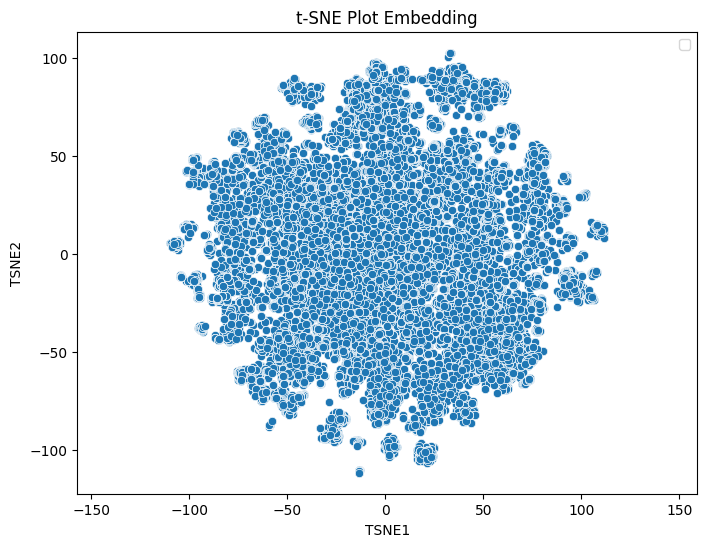

In [14]:
plotTSNE2D(df, 'tsne-2d-1', 'tsne-2d-2')

In [15]:
def plotTSNE3D(df, x_col, y_col, z_col, hue_col='id', highlight_points=None):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    cluster_colors = df[hue_col]
    sc = ax.scatter(df[x_col], df[y_col], df[z_col], c=cluster_colors, cmap='hsv')

    if(hue_col=='cluster'):
        colors = {0: 'blue', 1: 'orange', 2: 'green',3:'red', 4: 'purple', 5: 'brown', 6: 'pink', 7: 'gray'}
        cluster_colors = df[hue_col].map(colors)
        n_clusters = len(df[hue_col].unique())
        handles, labels = sc.legend_elements()
        ax.legend(handles, [f'Cluster {i}' for i in range(n_clusters)], title="Clusters")
    else:
        cluster_colors = df[hue_col]

    plt.colorbar(sc)
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_zlabel(z_col)
    plt.title('3D t-SNE Visualization')
    
    if(highlight_points!=None ):
        highlight_points = df.iloc[highlight_points]
        ax.scatter(
            highlight_points[x_col],
            highlight_points[y_col],
            highlight_points[z_col],
            color='black',
            s=100
        )
    
    plt.show()

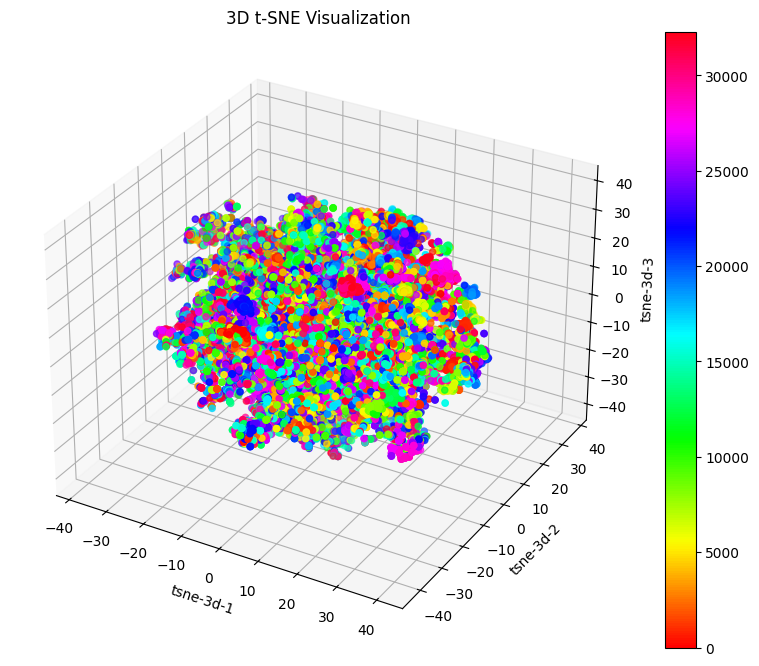

In [16]:
plotTSNE3D(df, 'tsne-3d-1', 'tsne-3d-2', 'tsne-3d-3')

# K-Means Clustering

Elbow Method: Optimal K seems to be 3 for the steepest decline

In [17]:
def elbowMethod(X, start, end):
    inertia_values = []
    k_range = range(start, end)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=123)
        kmeans.fit(X)
        inertia_values.append(kmeans.inertia_)

    plt.figure(figsize=(10, 6))
    plt.plot(k_range, inertia_values, marker='o')
    plt.title('Optimal K')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.xticks(k_range)
    plt.grid(True)

    plt.ylim(0, max(inertia_values) + (0.2 * max(inertia_values)))

    plt.show()

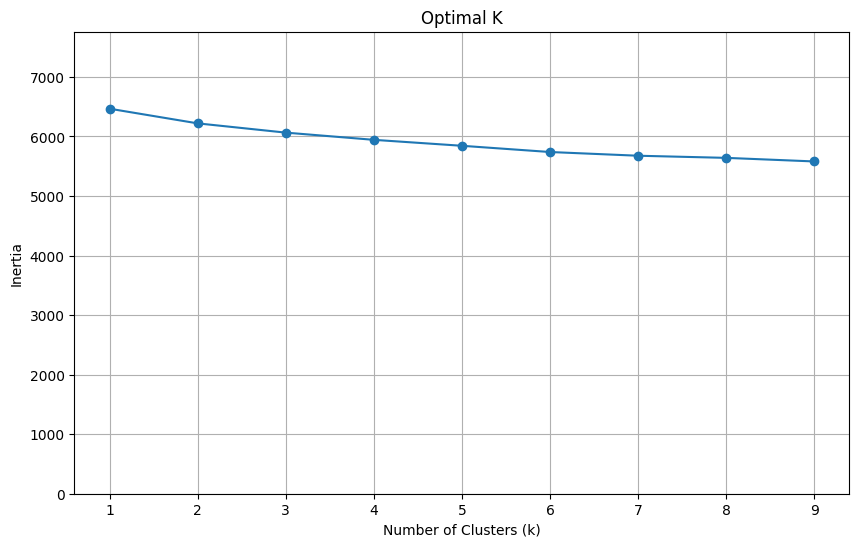

In [18]:
elbowMethod(X, 1, 10)

Fitting K-Means (Used 8 clusters to get categories)

In [17]:
# kmeans = KMeans(n_clusters=6, random_state=123).fit(X)
kmeans = KMeans(n_clusters=8, random_state=123).fit(X) # Tried 8 for more categories
df['cluster'] =  kmeans.labels_ 

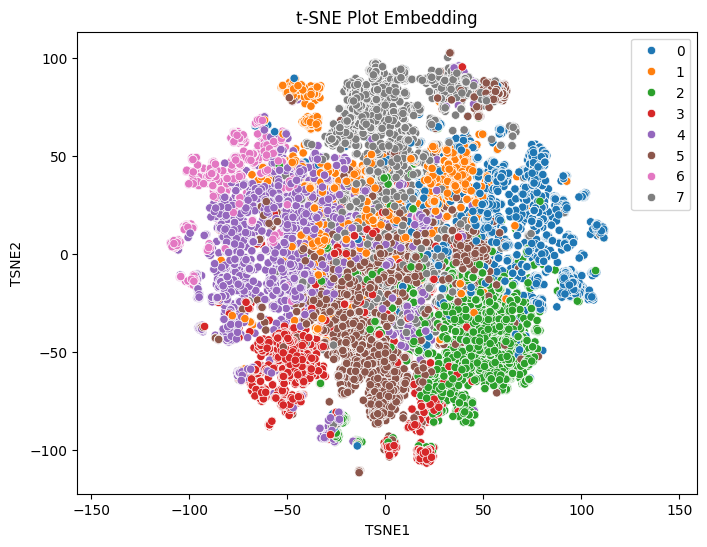

In [18]:
plotTSNE2D(df, 'tsne-2d-1', 'tsne-2d-2', hue_col='cluster')

In [22]:
# # to make the plot interactive
# matplotlib widget

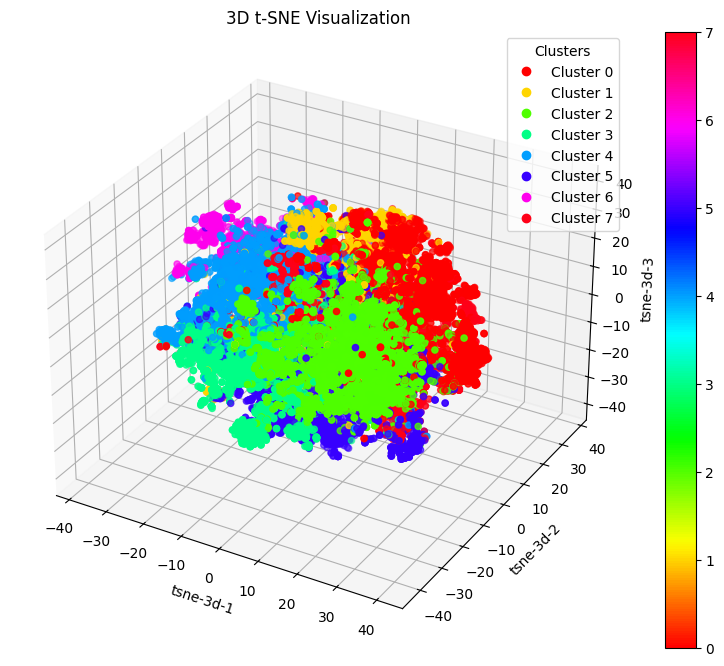

In [21]:
plotTSNE3D(df, 'tsne-3d-1', 'tsne-3d-2', 'tsne-3d-3', hue_col='cluster')

In [24]:
# # set it back so other graphs are not affected
# matplotlib inline

Save K-means to Pickle

In [96]:
with open('../data/kmeans_8_cluster.pkl', 'wb') as file:
    pickle.dump(kmeans, file)

## Analyze Source Distribution

In [25]:
def countSource(df):
    source_count = df['source'].value_counts()
    return source_count

def countClusterSource(df):
    source_count = df.groupby(['cluster', 'source']).size().unstack(fill_value=0)
    return source_count

In [26]:
def plotSourceCount(df):
    source_count = countClusterSource(df)
    ax = source_count.plot(kind='bar', stacked=True, figsize=(12, 8))
    ax.set_title('Source Counts per Cluster', fontsize=16)
    ax.set_xlabel('Cluster', fontsize=14)
    ax.set_ylabel('Number of Articles', fontsize=14)
    plt.xticks(rotation=0)
    plt.legend(title='Sources', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout() 
    plt.show()

def plotSourceCountEachCluster(df):
    sourceCountEachCluster = pd.crosstab(df['source'], df['cluster'])
    n_clusters = len(df['cluster'].unique())
    n_rows, n_cols = 2, 4
    n_sources = len(sourceCountEachCluster.index)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 12))
    axes = axes.flatten() # flatten the 2D array of axes to 1D
    
    for i, source in enumerate(sourceCountEachCluster.index):
        cluster_percentages = (sourceCountEachCluster.loc[source] / sourceCountEachCluster.loc[source].sum()) * 100
        
        ax = axes[i]
        ax.pie(
            cluster_percentages, 
            labels=[f'Cluster {j}' for j in range(n_clusters)], 
            autopct='%1.1f%%', 
            startangle=140
        )
        ax.set_title(source)

    for j in range(n_sources, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

def plotClusterDistribution(df):
    source_count = countClusterSource(df)
    source_majority_table = source_count.idxmax(axis=1)
    source_majority_table = source_majority_table.rename('Majority Cluster')
    summary_table = pd.DataFrame({
        'Biggest Source': source_majority_table,
        'Total Count': source_count.sum(axis=1)
    })    
    return summary_table

In [27]:
countSource(df)

source
kumparan         8571
okezone          7066
cnbcindonesia    4506
suara            4004
tempo            3642
cnnindonesia     3491
jawapos          1014
Name: count, dtype: int64

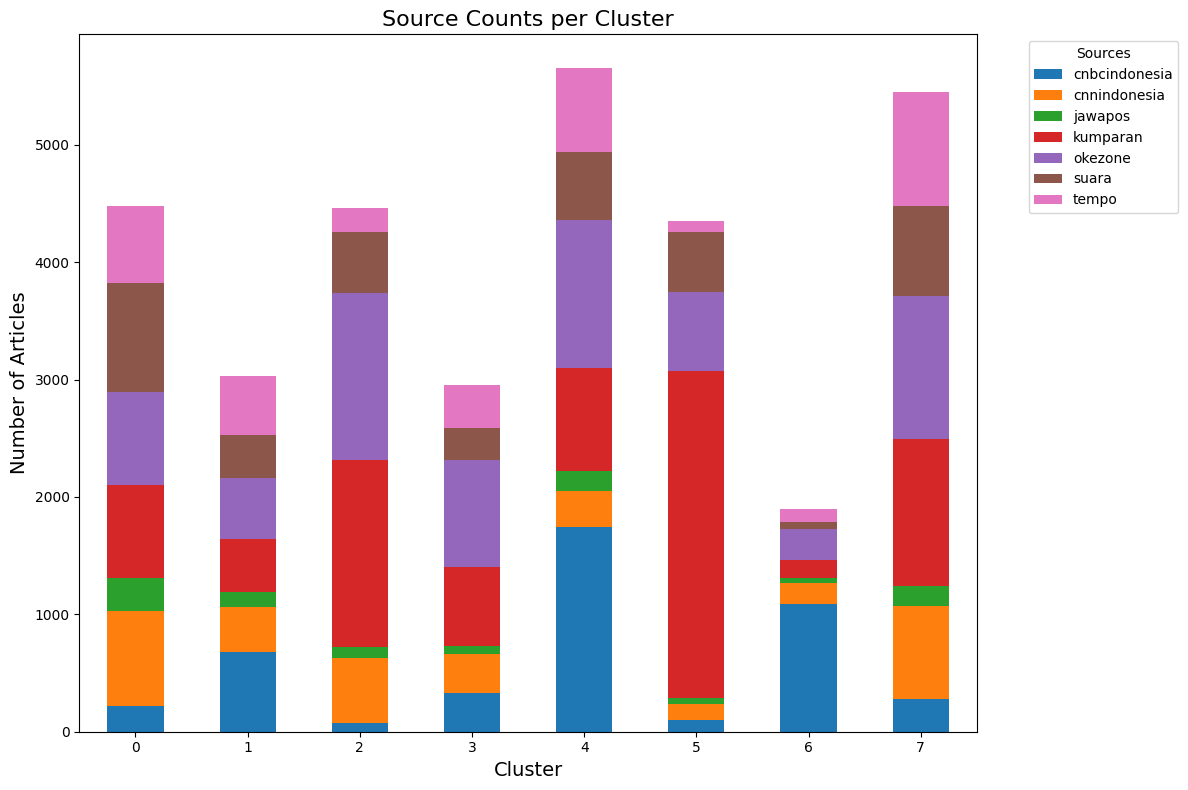

In [28]:
plotSourceCount(df)

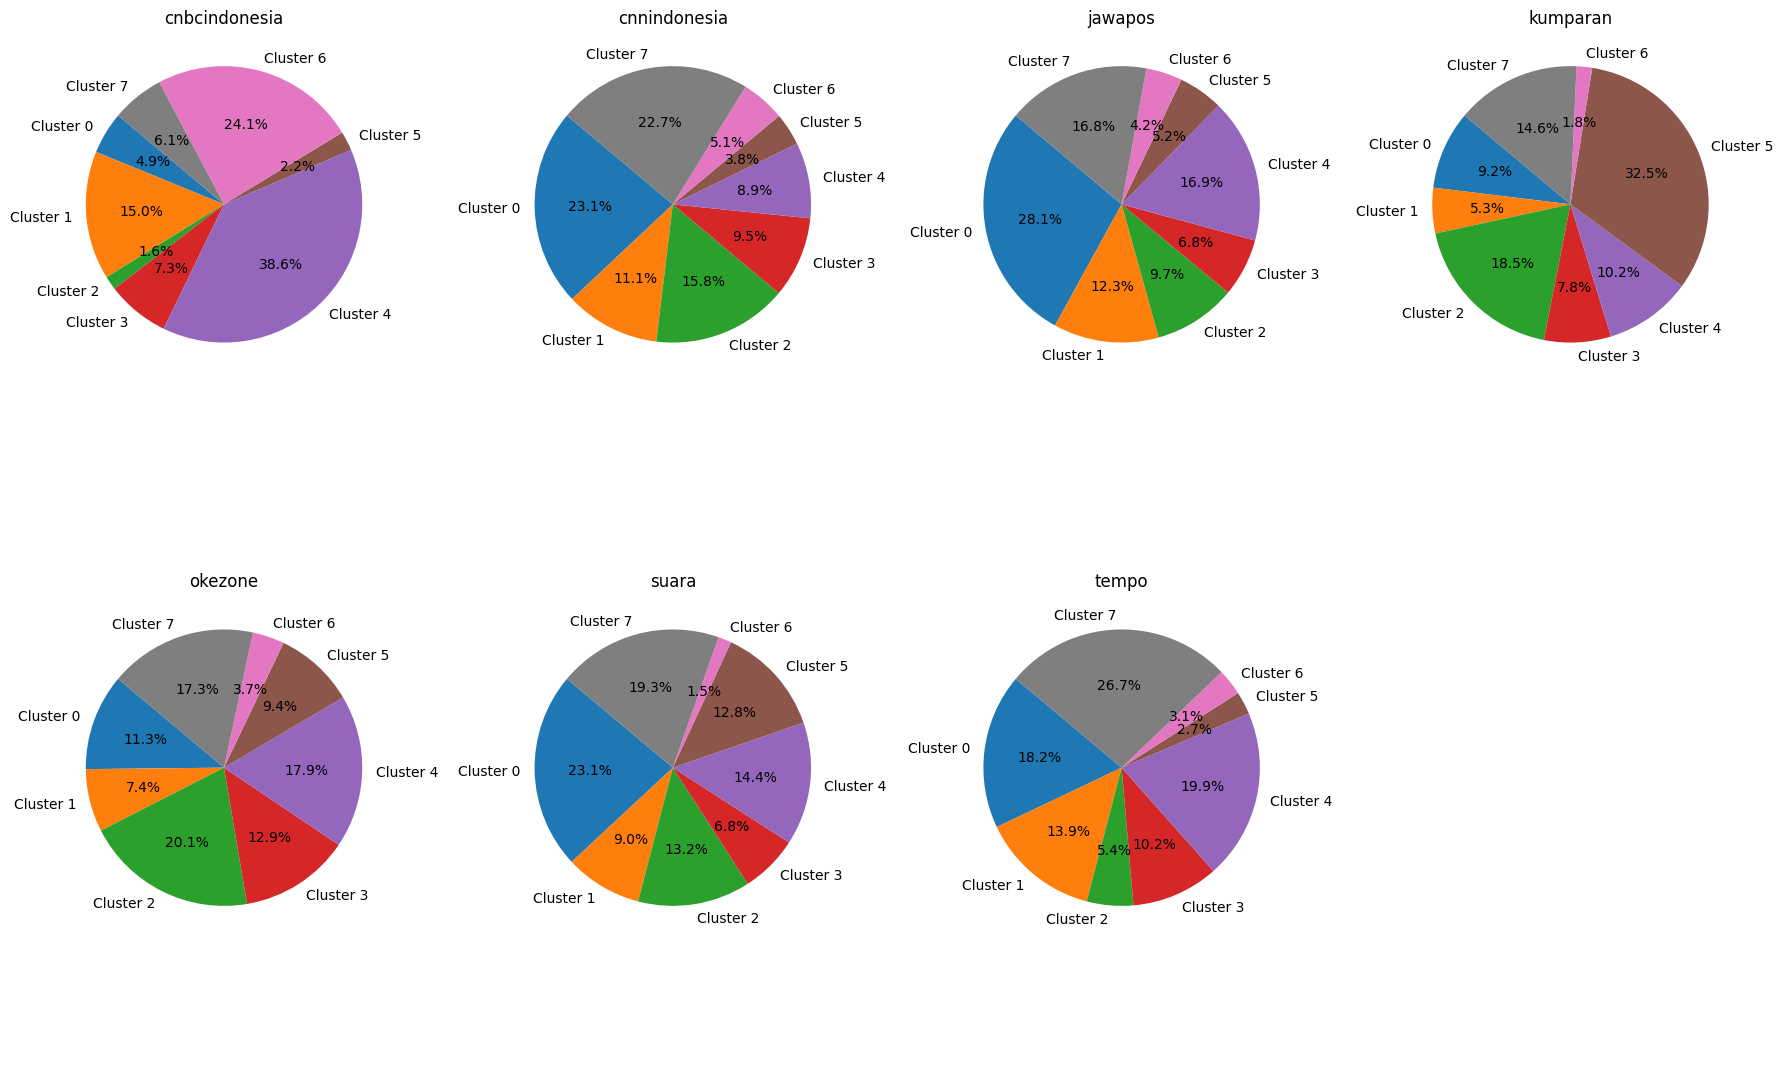

In [29]:
plotSourceCountEachCluster(df)

In [30]:
plotClusterDistribution(df)

Biggest Source  Total Count
cluster                            
0                suara         4483
1        cnbcindonesia         3031
2             kumparan         4459
3              okezone         2955
4        cnbcindonesia         5659
5             kumparan         4353
6        cnbcindonesia         1900
7             kumparan         5454

In [31]:
def createStopWordList(dir):
    stopWord_pd = pd.read_csv(dir, header=None)
    stopWordList = stopWord_pd[0].to_list()
    return stopWordList

def preprocessText(text, stopWordList):
    text = str(text)

    text = text.lower()

    text = re.sub(r'http\S+', '', text)

    text = re.sub(r'(@\w+|#\w+)', '', text)

    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    text = re.sub(r'\n', ' ', text)

    text = re.sub(r'\s{2,}', ' ', text)
    
    words = text.split()

    words = [word for word in words if word not in stopWordList]

    return words

In [32]:
stopWordList = createStopWordList('../data/stopWordList.csv')

In [33]:
def wordCountEachCluster(df, stopWordList):
    clusterWordCount = {}
    for cluster in df['cluster'].unique():
        clusterArticles = df[df['cluster'] == cluster]['content']
        
        allWords = []
        for article in clusterArticles:
            allWords.extend(preprocessText(article, stopWordList))
        
        wordCount = Counter(allWords)
        clusterWordCount[cluster] = wordCount
        
    clusterWordCount = dict(sorted(clusterWordCount.items()))
    return clusterWordCount

def plotClusterWordCount(clusterWordCount, top_n=30):
    fig, axes = plt.subplots(nrows=len(clusterWordCount), figsize=(10, len(clusterWordCount)*6))

    for i, (cluster, word_counts) in enumerate(clusterWordCount.items()):
        top_words = word_counts.most_common(top_n)
        words, counts = zip(*top_words)
        
        ax = axes[i] if len(clusterWordCount) > 1 else axes
        ax.barh(words, counts)
        ax.set_title(f'Cluster {cluster} - Top {top_n} Words')
        ax.set_xlabel('Frequency')
        ax.set_ylabel('Words')

    plt.tight_layout()
    plt.show()

In [34]:
clusterWordCount = wordCountEachCluster(df, stopWordList)

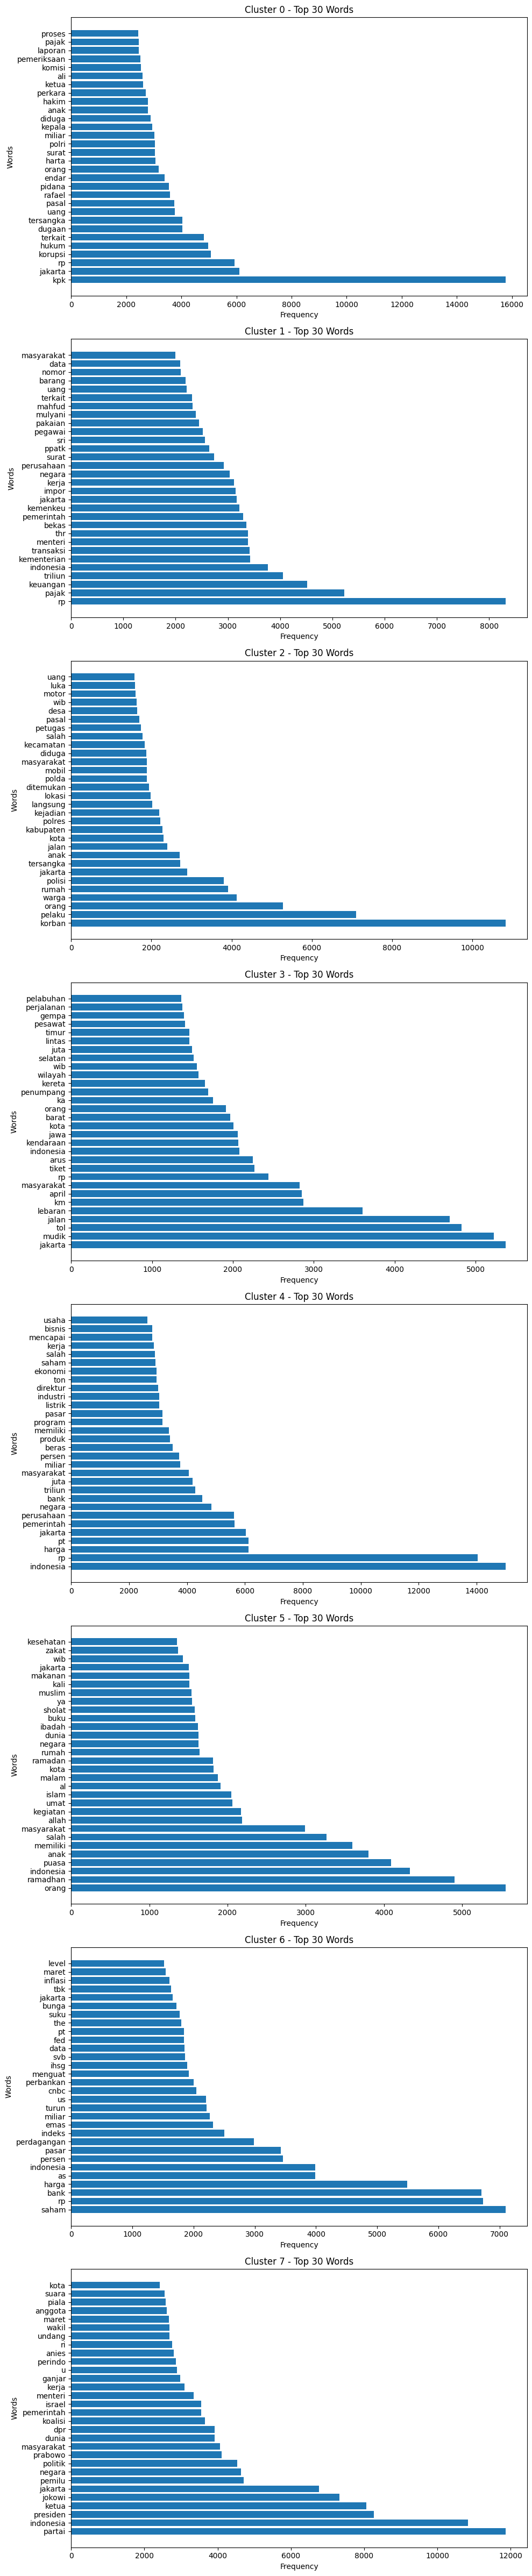

In [35]:
plotClusterWordCount(clusterWordCount, top_n=30)

# Research with Sample

In [36]:
def getNpEmbedding(embed_model, text):
    embedding = embed_model.get_text_embedding(text)
    return embedding, np.array(embedding, dtype=np.float32).reshape(1, -1)

def predictCluster(NpEmbedding, kmeans):
    predictedCluster = kmeans.predict(NpEmbedding)
    return predictedCluster

def getClusterCenter(kmeans):
    cluster_centers = kmeans.cluster_centers_
    return cluster_centers

def getDfofCluster(df, cluster):
    df_cluster = df[df['cluster'] == cluster]
    return df_cluster

In [37]:
def topWordsinCluster(clusterWordCount, cluster, top_n=100):
    topWordsCluster = clusterWordCount[cluster].most_common(top_n)
    topWordsCount = {word: count for word, count in topWordsCluster}

    for word, count in list(topWordsCount.items())[:10]:
        print(f"{word}: {count}")

    return topWordsCount

def topSimilarWords(text, pc, stopWordList, topWordsCount):
    textWords = preprocessText(text, stopWordList)

    textWordsCount = Counter(textWords)

    commonWordsCount = {word: textWordsCount[word] for word in textWords if word in topWordsCount}
    sortedCommonWordsCount = sorted(commonWordsCount.items(), key=lambda x: x[1], reverse=True)

    print(f"Predicted Cluster: {pc}")
    print(f"Common words in the new article that match top words in Cluster {pc}:")

    if sortedCommonWordsCount:
        for word, count in sortedCommonWordsCount:
            print(f"{word}: {count} / {topWordsCount[word]}")
    else:
        print("No common words found")

In [38]:
# sampleText = """
# Ibu Gregorius Ronald Tannur, Meirizka Widjaja telah tiba di Kejaksaan Agung (Kejagung RI) untuk dialkukan pemindahan penahanan setelah sebelumnya dilakukan di Surabaya setelah ditetapkan sebagai tersangka kasus dugaan suap demi vonis bebas Ronald Tannur dalam kasus tewasnya Dini Sera. Dia tiba di Kejagung dengan dibawa membawa mobil tahanan, Kamis (14/11/2024). Meirizka menggunakan rompi tahanan Kejaksaan Agung dengan tangan diborgol dan rambut terurai serta wajah tertutupi masker. Tidak satu kata pun yang disampaikan oleh Meirizka saat digelandang dari mobil menuju ke lift Gedung Kartika, Kejaksaan Agung. Meirizka ikut dipindahkan penahanan ke Jakarta setelah sebelumnya terlebih dahulu dilakukan oleh tiga hakim. Kepala Pusat Penerangan Hukum Kejagung Harli Siregar membenarkan adanya perpindahan penahanan terhadap Meirizka. Harli mengatakan pemindahan terhadap Meirizka dilakukan untuk mempermudah pemeriksaan terhadap Meirizka dalam perkara itu. Saat ini penyidik Kejagung terus melakukan pendalaman terkait aliran uang suap tersebut. "Untuk efektivitas penyidikan," ujar Harli. Sebelumnya, Kejaksaan Agung menetapkan Meirizka sebagai tersangka tersangka suap kepada para hakim melalui kuasa hukum Ronald Tannur, Lisa Rahmat. Meirizka sebelumnya memang memiliki kedekatan dengan Lisa sejak dibangku sekolah. Usai adanya persetujuan Lisa sebagai kuasa hukum dari terdakwa Ronald Tannur, Meirizka meminta Lisa untuk mengupayakan kasus hukum dari anaknya tersebut ke Pengadilan Negeri Surabaya. "Lisa menemui tersangka Zarof Ricar agar dapat memilih para hakim yang mengadili kasus anaknya tersebut," katanya. Dalam pertemuan antara Lisa dan para hakim yang akan mengurus kasus tersebut, Lisa mengajukan permintaan sejumlah uang yang akan diberikan kepada sejumlah hakim agar perkara Ronald Tannur dapat dibebaskan. Pada awal masa persidangan, Meirizka memberikan sejumlah uang senilai Rp1,5 miliar kepada Lisa sebagai biaya pengurusan kasus terpidana Ronald Tannur. Selanjutnya, Lisa juga menalangi uang biaya pengurusan kasus tersebut sebesar Rp2 miliar. “Totalnya Rp3,5 miliar. Terhadap uang tersebut menurut LR diberikan kepada majelis hakim yang mengadili perkara yang dimaksud,” ucap Qohar. Meirizka terbukti melanggar pasal 5 ayat 1 atau 6 ayat 1 huruf a juncto 18 UU No. 31 Tahun 1999 tentang tindak pidana korupsi sebagaimana diubah UU 20 Tahun 2001 perubahan 31 Tahun 1999 tentang tipikor juncto pasal 55 ayat 1 ke-1 KUHP.
# """
 
sample = df.sample()
sampleText = sample.iloc[0]['content']
df_sample = df.drop(sample.index) # Drop sample from df temporarily

In [39]:
sample[['source', 'title']]

source                                              title
28639  tempo  Antisipasi Lonjakan Konsumsi LPG dan BBM Saat ...

In [40]:
sampleEmbedding, sampleNpEmbedding = getNpEmbedding(embed_model, sampleText)
pc = predictCluster(sampleNpEmbedding, kmeans)[0]
pc

4

In [41]:
topWordsCount = topWordsinCluster(clusterWordCount, pc, top_n=100)

indonesia: 14992
rp: 14042
harga: 6123
pt: 6121
jakarta: 6035
pemerintah: 5650
perusahaan: 5632
negara: 4845
bank: 4525
triliun: 4280


In [42]:
topSimilarWords(sampleText, pc, stopWordList, topWordsCount)

Predicted Cluster: 4
Common words in the new article that match top words in Cluster 4:
pertamina: 9 / 2575
bbm: 5 / 1723
peningkatan: 3 / 1445
persen: 3 / 3725
masyarakat: 3 / 4061
unit: 3 / 1727
april: 2 / 1662
kebutuhan: 2 / 2177
utama: 2 / 2234
pt: 1 / 6121
energi: 1 / 2129
pemerintah: 1 / 5650
layanan: 1 / 2059
mobil: 1 / 1458


# Finding Similar Articles
Using cosine similarity to find nearest n embeddings

In [43]:
def topSimilarArticles(textEmbedding, df, n, method, reverse=True):
    if(method=='cosine'): #True = closest, False = furthest
        similarities = cosine_similarity([textEmbedding],list(df['embedding']))[0]
    elif(method=='euclidean'): #False = closest, True = furthest
        similarities = euclidean_distances([textEmbedding], list(df['embedding']))[0]

    similarities = list(enumerate(similarities))
    topSimilar = sorted(similarities, key=lambda x: x[1], reverse=reverse)
    topSimilar = topSimilar[:n]

    return topSimilar

def recommendationsFromTopSimilar(df, topSimilar):
    article_idx = [i[0] for i in topSimilar]
    similarity_values = [i[1] for i in topSimilar]

    recommendations = df.iloc[article_idx].copy()
    recommendations['similarity'] = similarity_values
    return recommendations

In [44]:
sampleEmbedding = sample.iloc[0]['embedding']

In [45]:
topSimilar = topSimilarArticles(sampleEmbedding, df_sample, 10, 'cosine', reverse=True)

In [46]:
recommendations = recommendationsFromTopSimilar(df_sample, topSimilar)

In [47]:
recommendations[['id', 'source', 'title', 'cluster', 'similarity']]

id         source  \
23211  23211        okezone   
27939  27939          tempo   
20542  20542       kumparan   
31973  31973        okezone   
32231  32231       kumparan   
31276  31276  cnbcindonesia   
31945  31945  cnbcindonesia   
30436  30436  cnbcindonesia   
30126  30126          tempo   
30485  30485  cnbcindonesia   

                                                   title  cluster  similarity  
23211  Pemudik Tenang, Pasokan BBM Dijamin Aman saat ...        3    0.950747  
27939  Mudik Lebaran, Pertamina Prediksi Konsumsi Gas...        4    0.950348  
20542  Jelang Lebaran, Pertamina Pastikan Pasokan BBM...        4    0.945227  
31973  Permintaan BBM dan LPG Naik pada Mudik Lebaran...        4    0.934226  
32231  Pertamina Siapkan Rp 4,8 T Tingkatkan Produksi...        4    0.934056  
31276  Jelang Puncak Arus Mudik, Pertamina Naikkan St...        4    0.931405  
31945  Sebelum Mudik Pastikan Keamanan LPG di Rumah, ...        3    0.930800  
30436  Konsumsi BBM Pertalite Diramal Melejit 10% di ...        4    0.930008  
30126  Cegah Kemacetan Antre SPBU, Pertamina Minta Ma...        3    0.929635  
30485  Jangan Takut Bensin Langka Saat Mudik, Ini Ske...        4    0.928737

In [48]:
listofRecc = [sample.iloc[0]['id']]
for i in range(10):
    listofRecc.append(recommendations.iloc[i]['id'])

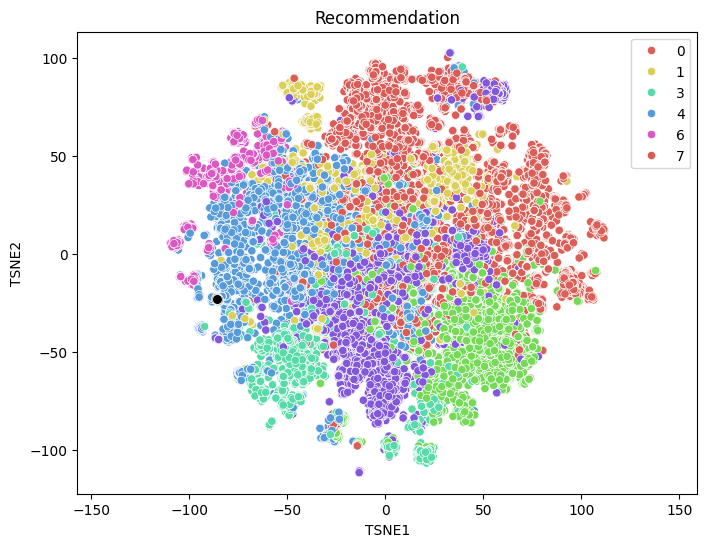

In [ ]:
plotTSNE2D(df, 'tsne-2d-1', 'tsne-2d-2', hue_col='cluster', highlight_points=listofRecc, title='Recommendation')

# Average Correct Predictions

In [50]:
def countCorrectPredictions(df, totalSamples, increment, kmeans):
   correctPredictions = 0
   accuracyProgress = []

   for i in range(1, totalSamples + 1):
      sample = df.sample().values[0]
      sampleEmbedding = sample[4]
      npSampleEmbedding = np.array(sampleEmbedding, dtype=np.float32).reshape(1, -1)
      
      pc = predictCluster(npSampleEmbedding, kmeans)[0]
      similarities = cosine_similarity([sampleEmbedding], list(df['embedding']))
      similarities = list(enumerate(similarities[0]))
      similarities = sorted(similarities, key=lambda x: x[1], reverse=True)[:10]
      articleIndex = [i[0] for i in similarities]
      recommendations = df.iloc[articleIndex]
      
      recommendedCluster = recommendations['cluster'].values
      correctPredictions += np.sum(recommendedCluster == pc)
      
      if i % increment == 0:
         accuracy = correctPredictions / (i * 10)  
         accuracyProgress.append((i, accuracy))

   return accuracyProgress

def plotAccuracyProgress(accuracyProgress):
   x = [point[0] for point in accuracyProgress]
   y = [point[1] for point in accuracyProgress]

   plt.figure(figsize=(10, 6))
   plt.plot(x, y, marker='o', linestyle='-', color='b')
   plt.title('Accuracy in Increments of 100 Samples')
   plt.xlabel('Number of Samples Processed')
   plt.ylabel('Accuracy')
   plt.ylim(0, 1)
   plt.grid(True)
   plt.show()

In [51]:
accuracyProgress = countCorrectPredictions(df, 1000, 100, kmeans)

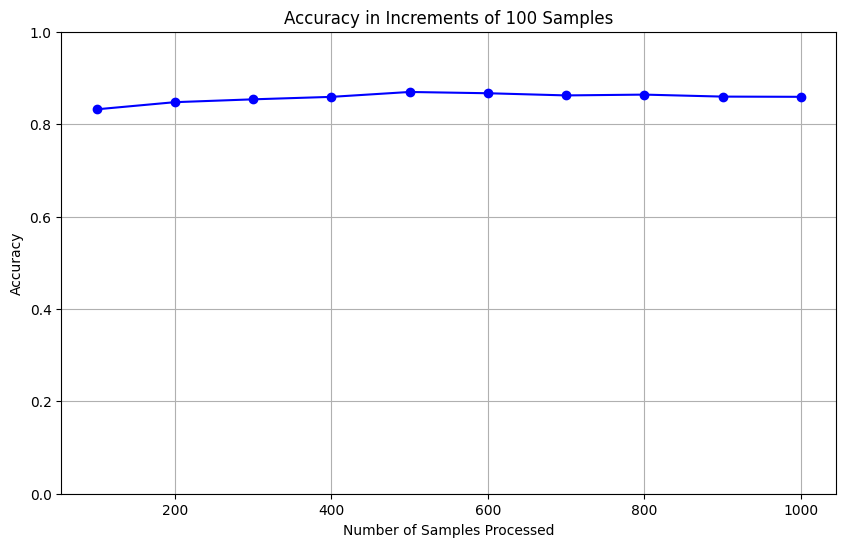

In [52]:
plotAccuracyProgress(accuracyProgress)

# Finding Dissimilar Articles
Cosine Similarity method (10 most dissimilar based on cosine)

In [53]:
topSimilar = topSimilarArticles(sampleEmbedding, df_sample, 10, 'cosine', reverse=False)
recommendations = recommendationsFromTopSimilar(df_sample, topSimilar)
recommendations[['id', 'source', 'title', 'cluster', 'similarity']]

id    source                                              title  \
8265    8265  kumparan  Billie Eilish Debut Akting di Serial Karya Chi...   
12595  12595  kumparan  Pengertian Sosiologi secara Etimologis beserta...   
12735  12735  kumparan  Pengertian dan Jenis Alat Musik Non Vokal Kord...   
8296    8296  kumparan  Arti dan Lawan Kata Suudzon sesuai Kamus Besar...   
28770  28770  kumparan  Ketahui Kunci Jawaban TTS untuk Pertanyaan Uni...   
5715    5715  kumparan  Pengertian dan Contoh Soal Determinan Matriks ...   
17078  17078  kumparan  Pengertian Ajaran Taoisme dari Tiongkok dan To...   
6010    6010   okezone  Segini Harta Kekayaan Michelle Yeoh, Wanita As...   
12885  12885  kumparan  Review John Wick: Chapter 4, Aksi Mendebarkan ...   
14387  14387   jawapos  Pengacara Sebut Dandy Kirim Video Penganiayaan...   

       cluster  similarity  
8265         5    0.712689  
12595        5    0.718197  
12735        5    0.721362  
8296         5    0.721465  
28770        5    0.722850  
5715         5    0.724248  
17078        5    0.724493  
6010         5    0.724618  
12885        5    0.724785  
14387        0    0.725523

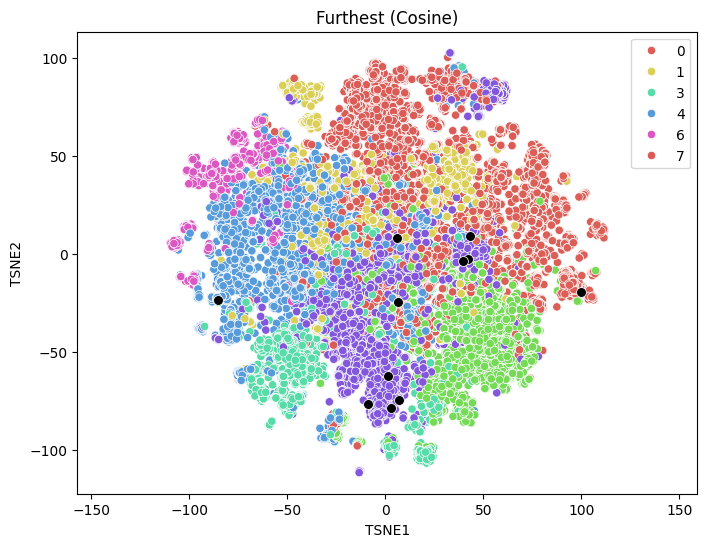

In [54]:
listofRecc = [sample.iloc[0]['id']]
for i in range(10):
    listofRecc.append(recommendations.iloc[i]['id'])

plotTSNE2D(df, 'tsne-2d-1', 'tsne-2d-2', hue_col='cluster', highlight_points=listofRecc, title='Furthest (Cosine)')

Antipode Method (10 nearest to opposite of embedding)

In [55]:
antipode_embedding = -np.array(sampleEmbedding)
topSimilar = topSimilarArticles(antipode_embedding, df_sample, 10, 'cosine', reverse=True)
recommendations = recommendationsFromTopSimilar(df_sample, topSimilar)
recommendations[['id', 'source', 'title', 'cluster', 'similarity']]

id    source                                              title  \
8265    8265  kumparan  Billie Eilish Debut Akting di Serial Karya Chi...   
12595  12595  kumparan  Pengertian Sosiologi secara Etimologis beserta...   
12735  12735  kumparan  Pengertian dan Jenis Alat Musik Non Vokal Kord...   
8296    8296  kumparan  Arti dan Lawan Kata Suudzon sesuai Kamus Besar...   
28770  28770  kumparan  Ketahui Kunci Jawaban TTS untuk Pertanyaan Uni...   
5715    5715  kumparan  Pengertian dan Contoh Soal Determinan Matriks ...   
17078  17078  kumparan  Pengertian Ajaran Taoisme dari Tiongkok dan To...   
6010    6010   okezone  Segini Harta Kekayaan Michelle Yeoh, Wanita As...   
12885  12885  kumparan  Review John Wick: Chapter 4, Aksi Mendebarkan ...   
14387  14387   jawapos  Pengacara Sebut Dandy Kirim Video Penganiayaan...   

       cluster  similarity  
8265         5   -0.712689  
12595        5   -0.718197  
12735        5   -0.721362  
8296         5   -0.721465  
28770        5   -0.722850  
5715         5   -0.724248  
17078        5   -0.724493  
6010         5   -0.724618  
12885        5   -0.724785  
14387        0   -0.725523

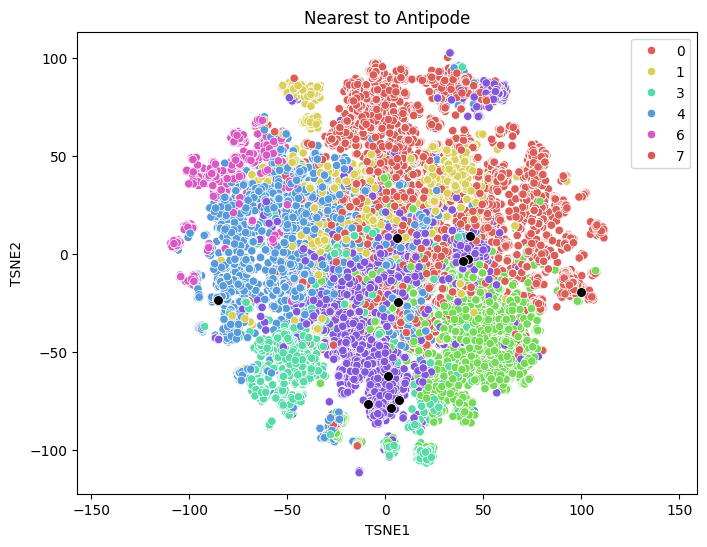

In [56]:
list_of_recc = [sample.iloc[0]['id']]
for i in range(10):
    list_of_recc.append(recommendations.iloc[i]['id'])
    
plotTSNE2D(df, 'tsne-2d-1', 'tsne-2d-2', hue_col='cluster', highlight_points=list_of_recc, title='Nearest to Antipode')

Euclidean Method (Finding 10 furthest distance)

In [57]:
topSimilar = topSimilarArticles(antipode_embedding, df_sample, 10, 'euclidean', reverse=False)
recommendations = recommendationsFromTopSimilar(df_sample, topSimilar)
recommendations[['id', 'source', 'title', 'cluster', 'similarity']]

id    source                                              title  \
8265    8265  kumparan  Billie Eilish Debut Akting di Serial Karya Chi...   
12595  12595  kumparan  Pengertian Sosiologi secara Etimologis beserta...   
12735  12735  kumparan  Pengertian dan Jenis Alat Musik Non Vokal Kord...   
8296    8296  kumparan  Arti dan Lawan Kata Suudzon sesuai Kamus Besar...   
28770  28770  kumparan  Ketahui Kunci Jawaban TTS untuk Pertanyaan Uni...   
5715    5715  kumparan  Pengertian dan Contoh Soal Determinan Matriks ...   
17078  17078  kumparan  Pengertian Ajaran Taoisme dari Tiongkok dan To...   
6010    6010   okezone  Segini Harta Kekayaan Michelle Yeoh, Wanita As...   
12885  12885  kumparan  Review John Wick: Chapter 4, Aksi Mendebarkan ...   
14387  14387   jawapos  Pengacara Sebut Dandy Kirim Video Penganiayaan...   

       cluster  similarity  
8265         5    1.850778  
12595        5    1.853751  
12735        5    1.855458  
8296         5    1.855513  
28770        5    1.856260  
5715         5    1.857013  
17078        5    1.857144  
6010         5    1.857212  
12885        5    1.857302  
14387        0    1.857699

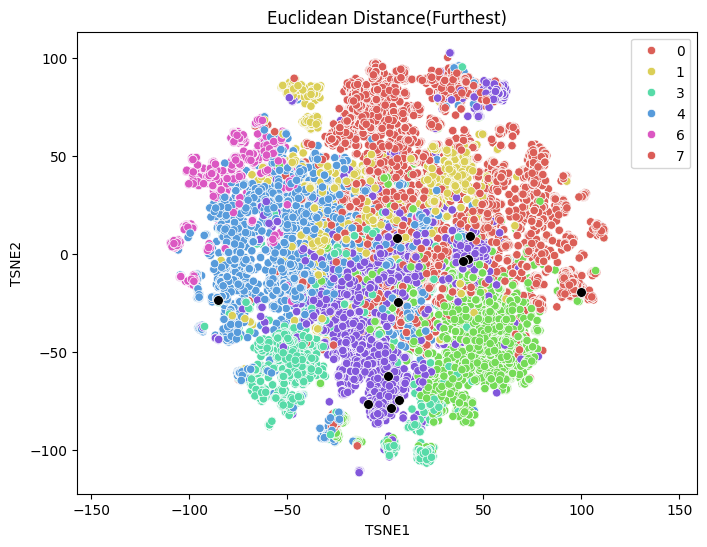

In [58]:
list_of_recc = [sample.iloc[0]['id']]
for i in range(10):
    list_of_recc.append(recommendations.iloc[i]['id'])
plotTSNE2D(df, 'tsne-2d-1', 'tsne-2d-2', hue_col='cluster', highlight_points=list_of_recc, title='Euclidean Distance(Furthest)')

# Two Most Dissimilar News Articles
- To check their position in graph

In [59]:
def MostDissimilarCosine(df):
    similarity_matrix = cosine_similarity(list(df['embedding']), list(df['embedding']))
    np.fill_diagonal(similarity_matrix, np.inf)
    min_similarity = np.min(similarity_matrix)
    row, col = np.unravel_index(np.argmin(similarity_matrix), similarity_matrix.shape)
    return row, col, min_similarity

In [60]:
def MostDissimilarEuclidean(df):
    distance_matrix = euclidean_distances(list(df['embedding']), list(df['embedding']))
    np.fill_diagonal(distance_matrix, -np.inf)
    min_similarity = np.max(distance_matrix)
    row, col = np.unravel_index(np.argmax(distance_matrix), distance_matrix.shape)
    return row, col, min_similarity

Cosine similarity method

In [61]:
# row, col, min_similarity = MostDissimilarCosine(df)
# print(f"Most Dissimilar Pair of Articles by Cosine Similarity: {row}, {col}")
# print(f"Cosine similarity: {min_similarity}")

# print("Text 1:", df.iloc[row]['title'])  
# print("Text 2:", df.iloc[col]['title'])

In [62]:
# plotTSNE2D(df, 'tsne-2d-1', 'tsne-2d-2', hue_col='cluster', highlight_points=[row, col], title='Most Dissimilar Cosine')

In [63]:
# %matplotlib widget

In [64]:
# plotTSNE3D(df, 'tsne-3d-1', 'tsne-3d-2', 'tsne-3d-3', hue_col='cluster', highlight_points=[row, col])

In [65]:
# %matplotlib inline

Euclidean Method (Results show the same)

In [66]:
# row, col, min_similarity = MostDissimilarEuclidean(df)

In [67]:
# print(f"Most Dissimilar Pair of Articles by Euclidean Distance: {row}, {col}")
# print(f"Euclidean Distance: {min_similarity}")

# print("Text 1:", df.iloc[row]['title'])  
# print("Text 2:", df.iloc[col]['title'])

# Run the sample and 10 recommendations to model

In [68]:
sample = df.sample()
sampleText = sample.iloc[0]['content']
df_sample = df.drop(sample.index)
sampleEmbedding = sample.iloc[0]['embedding']
topSimilar = topSimilarArticles(sampleEmbedding, df_sample, 10, 'cosine', reverse=True)
recommendations = recommendationsFromTopSimilar(df_sample, topSimilar)
recommendations[['id', 'source', 'title', 'cluster', 'similarity']]

id         source  \
26081  26081          suara   
23386  23386          tempo   
25905  25905          suara   
26119  26119          suara   
23202  23202  cnbcindonesia   
22738  22738          suara   
22733  22733          suara   
24433  24433        okezone   
29083  29083        okezone   
22477  22477          tempo   

                                                   title  cluster  similarity  
26081  Daftar Bisnis Dito Ariotedjo Sebelum Jadi Menpora        7    0.967778  
23386  Menpora Dito Ariotedjo Langsung Dapat Tugas In...        7    0.957447  
25905  Pengamat Desak Menpora Rangkul Semua Komunitas...        7    0.956191  
26119  Menpora Dito Ariotedjo Langsung Dapat Arahan d...        7    0.955248  
23202  Simak 3 'Titipan' Jokowi untuk Menpora Dito Ar...        7    0.952127  
22738  Harta Kekayaan Dito Ariotedjo: Menpora Baru Te...        7    0.950075  
22733  Hari Ini Dilantik Jadi Menpora, Dito Ariotedjo...        7    0.949100  
24433  Bisnis dan Sumber Kekayaan Dito Ariotedjo, Men...        7    0.946260  
29083  4 Fakta Dito Ariotedjo Eks Anak Bos Antam Jadi...        7    0.946166  
22477  Profil Dito Ariotedjo, Calon Menpora yang Baka...        7    0.946076

In [69]:
model = load_model('../model/hoax_detection_A3.h5')
with open('../model/tokenizer_A3.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

In [70]:
allArticles = [sampleText] + list(recommendations['content'])

allSequences = tokenizer.texts_to_sequences(allArticles)
paddedAllSequences = pad_sequences(allSequences, maxlen=100, padding='post', truncating='post')

predictedProbabilities = model.predict(paddedAllSequences)
predictedClasses = (predictedProbabilities > 0.5).astype(int)
predictions = ["Fake" if pred == 1 else "Real" for pred in predictedClasses]
recommendations['newsRealorFake'] = predictions[1:]
print(recommendations[['source', 'title', 'newsRealorFake']])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
              source                                              title  \
26081          suara  Daftar Bisnis Dito Ariotedjo Sebelum Jadi Menpora   
23386          tempo  Menpora Dito Ariotedjo Langsung Dapat Tugas In...   
25905          suara  Pengamat Desak Menpora Rangkul Semua Komunitas...   
26119          suara  Menpora Dito Ariotedjo Langsung Dapat Arahan d...   
23202  cnbcindonesia  Simak 3 'Titipan' Jokowi untuk Menpora Dito Ar...   
22738          suara  Harta Kekayaan Dito Ariotedjo: Menpora Baru Te...   
22733          suara  Hari Ini Dilantik Jadi Menpora, Dito Ariotedjo...   
24433        okezone  Bisnis dan Sumber Kekayaan Dito Ariotedjo, Men...   
29083        okezone  4 Fakta Dito Ariotedjo Eks Anak Bos Antam Jadi...   
22477          tempo  Profil Dito Ariotedjo, Calon Menpora yang Baka...   

      newsRealorFake  
26081           Fake  
23386           Real  
25905           Fake  
26119           Real  
23202           Real

In [71]:
with open('../model/bias_tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

interpreter = tf.lite.Interpreter(model_path='../model/bias_detection_lstm.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


In [72]:
newSequences = tokenizer.texts_to_sequences(allArticles)
maxLen = 30
new_padded = pad_sequences(newSequences, maxlen=maxLen)

new_padded = new_padded.astype('float32')

results = []

for i, article_padded in enumerate(new_padded):
    interpreter.set_tensor(input_details[0]['index'], article_padded.reshape(1, -1))
    interpreter.invoke()
    
    predictionsTfLite = interpreter.get_tensor(output_details[0]['index'])
    
    predictedLabelsTfLite = 1 if predictionsTfLite[0] > 0.5 else 0
    textLabel = "Bias" if predictedLabelsTfLite == 1 else "Netral"
    
    results.append(textLabel)

recommendations['isBiased'] = results[1:] 

print(recommendations[['source', 'title', 'newsRealorFake', 'isBiased']])

              source                                              title  \
26081          suara  Daftar Bisnis Dito Ariotedjo Sebelum Jadi Menpora   
23386          tempo  Menpora Dito Ariotedjo Langsung Dapat Tugas In...   
25905          suara  Pengamat Desak Menpora Rangkul Semua Komunitas...   
26119          suara  Menpora Dito Ariotedjo Langsung Dapat Arahan d...   
23202  cnbcindonesia  Simak 3 'Titipan' Jokowi untuk Menpora Dito Ar...   
22738          suara  Harta Kekayaan Dito Ariotedjo: Menpora Baru Te...   
22733          suara  Hari Ini Dilantik Jadi Menpora, Dito Ariotedjo...   
24433        okezone  Bisnis dan Sumber Kekayaan Dito Ariotedjo, Men...   
29083        okezone  4 Fakta Dito Ariotedjo Eks Anak Bos Antam Jadi...   
22477          tempo  Profil Dito Ariotedjo, Calon Menpora yang Baka...   

      newsRealorFake isBiased  
26081           Fake     Bias  
23386           Real     Bias  
25905           Fake   Netral  
26119           Real     Bias  
23202         

In [73]:
documents = []
for index, row in recommendations.iterrows():
    document = Document(
    text=row['content'],
    doc_id=str(row['id']),
    metadata={
        'title': row['title'],
        'source': row['source'],
        'isBiased': row['isBiased'],
        'newsRealorFake': row['newsRealorFake']
    },
    embedding=(row['embedding'])
    )
    documents.append(document)

In [74]:
def createVectorIndex(documents):
    index = VectorStoreIndex.from_documents(documents)
    index.storage_context.persist(persist_dir="../storage")

def loadVectorIndex():
    storage_context = StorageContext.from_defaults(persist_dir="../storage")
    index = load_index_from_storage(storage_context)
    return index

In [75]:
# createVectorIndex(documents)

In [76]:
# index = loadVectorIndex()

In [77]:
index = VectorStoreIndex.from_documents(documents)

In [78]:
query_str = (
    "News Article Title: " + sample.iloc[0]['title'] + "\n"
    "News Article Content: " + sampleText + "\n"
    "News Article Source: " + sample.iloc[0]['source'] + "\n"
    "News Article Bias (Biased/Netral): " + recommendations.iloc[0]['isBiased'] + "\n"
    "News Article is detected to be: " + recommendations.iloc[0]['newsRealorFake']
)

print(query_str)

News Article Title: Dito Ariotedjo, Menteri Termuda yang Berjanji Bakal Diet Ketat
News Article Content: Suara.com - Ario Bimo Nandito Ariotedjo atau lebih dikenal sebagai Dito Ariotedjo resmi dilantik Presiden Joko Widodo atau Jokowi sebagai Menteri Pemuda dan Olahraga ( Menpora ) pada Senin (3/4/2023). Usai dilantik, Dito sempat menyinggung berat badannya. Pada pelantikan, perawakan Dito mencuri perhatian karena tubuhnya yang tinggi besar. Karena sudah dilantik menjadi orang nomor satu untuk mengurusi perihal olahraga nasional, berat badannya pun menjadi perhatian bagi dirinya sendiri. "Tapi ada satu sih yang perlu dikurangin kalau dari saya, itu berat badan saya pasti," kata Dito di Kompleks Istana Kepresidenan, Senin. Setelah dilantik, Dito bertekad untuk menurunkan berat badannya secara ketat. "Jadi kita hari ini diet makin keras, latihan makin keras," tutur pria 32 tahun tersebut. Selain itu, Dito mendapatkan tiga arahan dari Jokowi setelah dilantik. Pertama, Jokowi ingin ada cab

In [79]:
instruction = """
You are a news article analyzer capable of determining political bias by analyzing what is being highlighted. Please provide an explanation of why you chose a particular side, citing specific examples from the text that demonstrate its alignment. Do not speak in first person.

Assess the article using the following bias ratings:
Neutral: The article presents balanced coverage with no clear lean toward any political side, offering both governmental and opposition views fairly or taking no sides. It avoids strong language or overt opinions, focusing on facts and events without significant framing or bias.
Progressive: The article tends to highlight progressive social, economic, or political reforms. It may support the expansion of civil rights, greater equality, or address sensitive issues like minority rights or environmental concerns. A progressive stance is often more critical of the status quo and may push for change.
Conservative: The article tends to highlight traditional values, maintaining or returning to the status quo. It often aligns with religious or nationalistic views and may criticize progressive movements or policies that challenge these traditional values.
Critical: The article critiques the government. While it may be negative or adversarial, it can also be constructive in its criticism, highlighting flaws, mismanagement, or policies that need reform. Critical content does not shy away from highlighting issues or injustices.

Expected Answer:
Bias Rating: Rate the article and explain your choice of Bias (if it is biased as specified) with brief examples from the text.
Hoax Rating: Compare the article with the information you have. Explain which part of the given article is different if any.
Key Indicators of Bias: Explain if there are any opinionated content, selective facts, extreme language, persuasive tactics, unsupported claims, anonymity, entertainment-based content, or disguised sales pitches.
Conclusion: Summarize findings of bias and hoax, mentioning if there were any nuances or mixed signals.
"""

In [80]:
retriever = VectorIndexRetriever(
    index=index,
    similarity_top_k=10,
)

response_synthesizer = get_response_synthesizer()

class CustomRetrieverQueryEngine(RetrieverQueryEngine):
    def query(self, query_text: str):
        retrieverResults = self.retriever.retrieve(query_text)
        return super().query(query_text)

query_engine = CustomRetrieverQueryEngine(
    retriever=retriever,
    response_synthesizer=response_synthesizer,
    node_postprocessors=[SimilarityPostprocessor(similarity_cutoff=0.5)],
)

In [81]:
# response = query_engine.query(instruction + query_str)
# print(response)

In [82]:
newId = int(df['id'].max() + 1)
source = 'cnn'
content = """Jakarta, CNN Indonesia -- Menteri Agama Nasaruddin Umar melalui Tenaga Ahli Muhammad Ainul Yaqin melaporkan barang gratifikasi ke Komisi Pemberantasan Korupsi (KPK), Selasa (26/11). Ainul tidak menjelaskan detail mengenai barang dimaksud. Ia juga mengaku tidak mengetahui pihak pemberi."Bentuknya barang. Kami sudah serahkan ke dalam," kata Ainul di Gedung Pusat Edukasi Antikorupsi KPK, Selasa (26/11) siang. Ainul menuturkan barang tersebut diterima menteri Nasaruddin pada Jumat (22/11) lalu dan diputuskan untuk dilaporkan pada hari ini. Ia menyebut jajaran pada Direktorat Gratifikasi KPK telah menerima pengembalian barang. "Tidak ada nama [yang tertera di barangnya]. Kami sudah serahkan, diterima langsung oleh Ibu Indira Kasatgas Gratifikasi KPK. Sudah diterima langsung oleh Ibu Kasatgas," ujarnya. Ainul menambahkan keputusan tersebut menunjukkan komitmen Nasaruddin dalam menjalankan pemerintahan yang bersih dari korupsi, kolusi dan nepotisme (KKN). "Ini bagian dari komitmen beliau, sesuai dengan arahan dan pidato beliau di beberapa tempat, untuk di Kementerian Agama ini sebagai contoh, sebagai teladan good governance," katanya."""
embedding, npEmbedding = getNpEmbedding(embed_model, content)
cluster = predictCluster(npEmbedding, kmeans)[0]
title = 'Menteri Agama Nasaruddin Umar Laporkan Barang Gratifikasi ke KPK'

newEntry = pd.DataFrame([{
    'id': id,
    'source': source,
    'title': title,
    'content': content,
    'embedding': embedding,
    'cluster': cluster
}])


In [83]:
newEntry[['title', 'source', 'cluster']]

title source  cluster
0  Menteri Agama Nasaruddin Umar Laporkan Barang ...    cnn        0

In [84]:
df_new = pd.concat([df, newEntry], ignore_index=True)

In [85]:
X_newEntry = np.array(embedding, dtype=np.float32).reshape(1, -1)
X_new = np.append(X, X_newEntry, axis=0)

In [86]:
tsne_results_2d = reduceDimension(X_new, 50)

In [87]:
df_new = convertTSNEtoDF(df_new, tsne_results_2d)

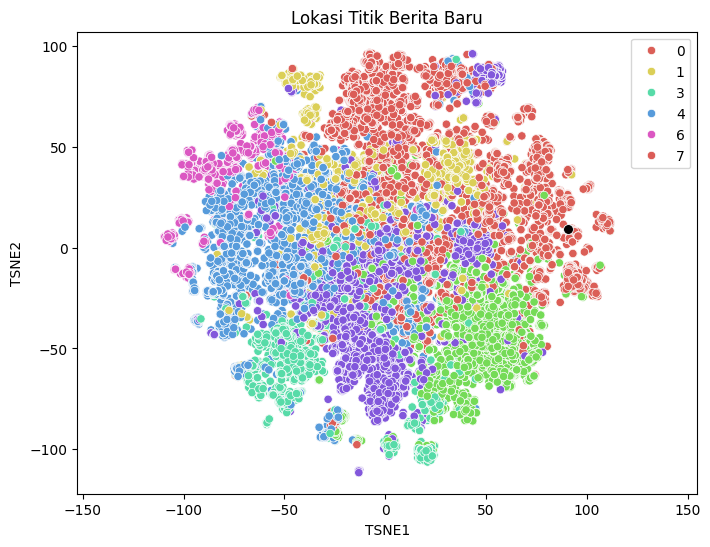

In [88]:
plotTSNE2D(df_new, 'tsne-2d-1', 'tsne-2d-2', hue_col='cluster', highlight_points=[newId], title='Lokasi Titik Berita Baru')

In [89]:
# Find antipode
antipode_embedding = -np.array(embedding)

# Nearest to antipode
topSimilar = topSimilarArticles(antipode_embedding, df_new, 10, 'cosine', reverse=True)
recommendations = recommendationsFromTopSimilar(df_new, topSimilar)
recommendations[['id', 'source', 'title', 'cluster', 'similarity']]

id    source                                              title  \
13828  13828  kumparan  Karakteristik Perempuan Aries, Kompetitif dan ...   
27467  27467  kumparan             Ramalan Zodiak Pisces Bulan April 2023   
8074    8074  kumparan  Selena Gomez Jadi Perempuan Pertama yang Punya...   
25376  25376  kumparan              Ramalan Zodiak Virgo Bulan April 2023   
25371  25371  kumparan              Ramalan Zodiak Libra Bulan April 2023   
7181    7181  kumparan  3 Contoh Soal Tekanan Hidrostatis Beserta Jawa...   
15608  15608  kumparan  Jalur Pejalan Kaki Terpanjang di Dunia: Tempuh...   
12364  12364  kumparan  Cara Baca Hasil Pemeriksaan Hematologi Rutin d...   
4269    4269  kumparan  Contoh Soal Volume Bola dan Kunci Jawabannya d...   
27878  27878  kumparan  Head to Head Tottenham vs Brighton di Liga Ing...   

       cluster  similarity  
13828        5   -0.717222  
27467        5   -0.722224  
8074         5   -0.728754  
25376        5   -0.729060  
25371        5   -0.729519  
7181         5   -0.731299  
15608        3   -0.731420  
12364        5   -0.733450  
4269         5   -0.733630  
27878        5   -0.734934

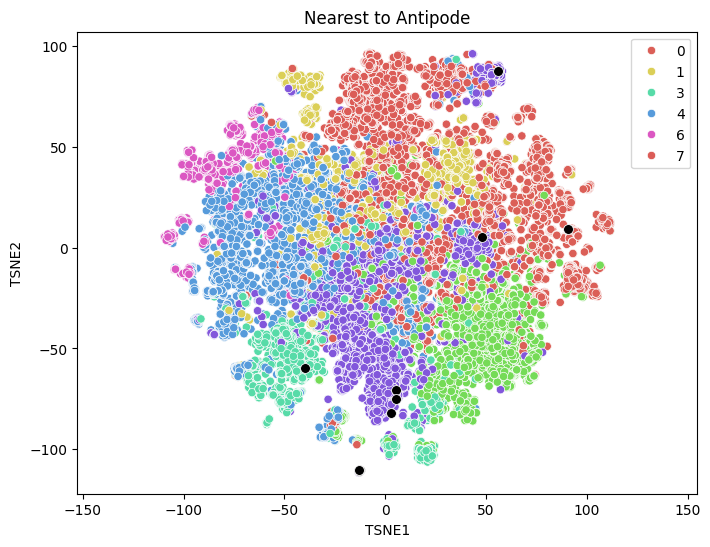

In [90]:
list_of_recc = [newId]
for i in range(10):
    list_of_recc.append(recommendations.iloc[i]['id'])
    
plotTSNE2D(df_new, 'tsne-2d-1', 'tsne-2d-2', hue_col='cluster', highlight_points=list_of_recc, title='Nearest to Antipode')

In [91]:
# Top similar
topSimilar = topSimilarArticles(embedding, df_new, 10, 'cosine', reverse=True)

In [92]:

recommendations = recommendationsFromTopSimilar(df_new, topSimilar)
recommendations[['id', 'source', 'title', 'cluster', 'similarity']]

id         source  \
32294  <built-in function id>            cnn   
3469                     3469        okezone   
5148                     5148          tempo   
21053                   21053        okezone   
3378                     3378   cnnindonesia   
614                       614  cnbcindonesia   
2891                     2891        jawapos   
29867                   29867          suara   
128                       128          tempo   
22873                   22873          suara   

                                                   title  cluster  similarity  
32294  Menteri Agama Nasaruddin Umar Laporkan Barang ...        0    1.000000  
3469   KPK Terima Laporan IPW Terkait Dugaan Gratifik...        0    0.901102  
5148   Ketua IPW Laporkan Wamenkumham karena Dugaan G...        0    0.896726  
21053  Rafael Alun Tersangka Kasus Korupsi, Stafsus S...        0    0.896637  
3378   KPK Verifikasi Laporan IPW soal Dugaan Gratifi...        0    0.896034  
614    Lho! KPK Tak Tahu Soal Transaksi Gelap Rp 300 ...        1    0.895021  
2891   KPK Diminta Responsif Soal Pelaporan Wamenkumh...        0    0.894832  
29867  Dianggap Tahu Kasus Rafael Alun, 2 Orang Ibu R...        0    0.893644  
128    Eks Gubernur Aceh Irwandi Yusuf Dicekal KPK ke...        0    0.893178  
22873  Deretan Tas Mewah Bermerk Jadi Barang Bukti Du...        0    0.893146

In [93]:
list_of_recc = [newId]
for i in range(1,10):
    list_of_recc.append(recommendations.iloc[i]['id'])


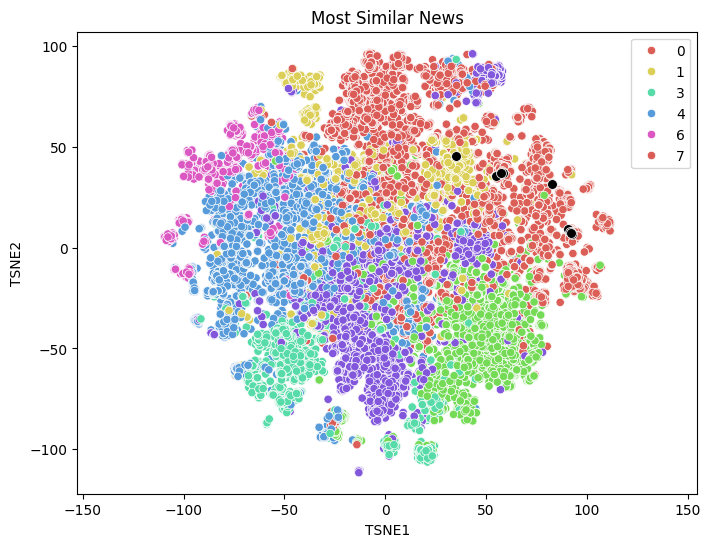

In [94]:
plotTSNE2D(df_new, 'tsne-2d-1', 'tsne-2d-2', hue_col='cluster', highlight_points=list_of_recc, title='Most Similar News')